# DRIFT - DEFENSIVE RISK-INFORMED FLASH-CRASH TRADER

## INTRODUCTION

**Crypto Flash Crashes: Billions Vanish in Minutes**

Imagine May 2022: Terra/Luna crashes 99% in hours, wiping out $40B. ETH drops 50%, AVAX 60%. Most traders get liquidated. **Our mission? Survive unscathed.**

**Problem 1 Challenge**

- **Survive** flash crashes without total loss
- **Minimize** drawdowns (<10% target) 
- **Recover** capital in days, not months

**The Solution**

A strategy across 5 crypto assets (Anchor, Polygon, Terra, ETH, AVAX) that:
- Detects volatility explosions before price collapse
- Cuts positions during systemic panic (≥2 assets spiking)
- Re-enters smartly using trend + recovery signals
- Enforces hard stops: -10% per asset, -8% portfolio

This isn't buy and hold. It's **intelligent risk control** for crypto's wildest moments.

## DATA IMPORTS AND PREPROCESSING

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

FEE = 0.001

In [2]:
def load_asset_csv(path, price_col="price"):
    df = pd.read_csv(path)
    df = df.rename(columns={price_col: "price"})
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)
    df["return"] = df["price"].pct_change()
    df["log_return"] = np.log(df["price"] / df["price"].shift(1))
    df = df.dropna().reset_index(drop=True)
    return df

In [3]:
anchor_df   = load_asset_csv("anchor-protocol.csv")
polygon_df  = load_asset_csv("polygon.csv")
terra_df    = load_asset_csv("terra-luna.csv")
eth_df      = load_asset_csv("ethereum.csv")
avax_df     = load_asset_csv("avalanche.csv")

assets = {
    "anchor": anchor_df,
    "polygon": polygon_df,
    "terra": terra_df,
    "eth": eth_df,
    "avax": avax_df,
}

## FEATURE ENGINEERING

In [4]:
def add_core_features(df):
    df = df.copy()

    df["log_ret"] = np.log(df["price"]).diff()
    df["ret"] = df["price"].pct_change()

    df["vol_short"] = df["log_ret"].rolling(20).std()
    df["vol_long"] = df["log_ret"].rolling(60).std()

    df["rolling_min_10"] = df["price"].rolling(10).min()
    df["rolling_max_60"] = df["price"].rolling(60).max()

    df["ema_fast"] = df["price"].ewm(span=10, adjust=False).mean()
    df["ema_slow"] = df["price"].ewm(span=30, adjust=False).mean()

    eq = (1 + df["ret"].fillna(0)).cumprod()
    peak = eq.cummax()
    df["price_dd"] = eq / peak - 1.0

    return df.dropna().reset_index(drop=True)

def add_crash_label(df, horizon=1, crash_threshold=-0.05):
    df = df.copy()
    fwd_ret = df["price"].shift(-horizon) / df["price"] - 1.0
    df["y_crash"] = (fwd_ret <= crash_threshold).astype(int)
    return df

assets = {k: add_core_features(v) for k, v in assets.items()}
assets = {k: add_crash_label(v) for k, v in assets.items()}

## DATASET ANALYSIS (PLOTS)

In [5]:
import seaborn as sns

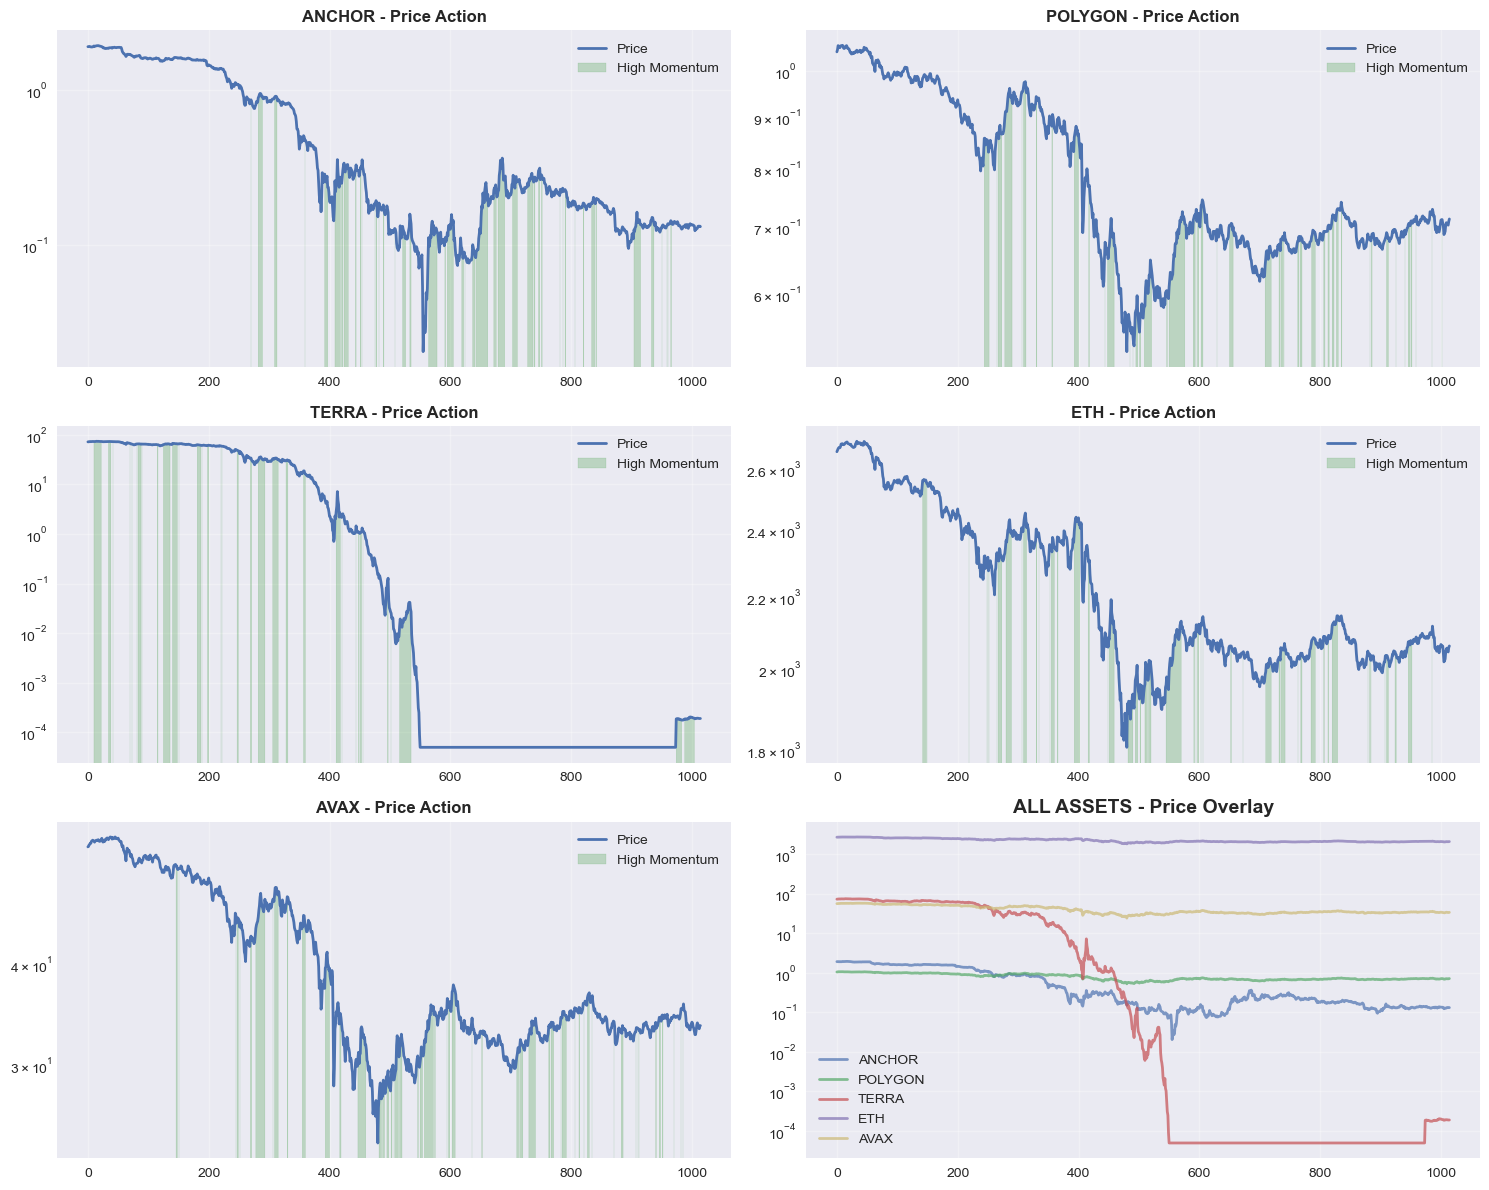

In [6]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (name, df) in enumerate(list(assets.items())[:5]):
    ax = axes[i]
    
    ax.plot(df.index, df['price'], linewidth=2, label='Price')
    ax.set_yscale('log')
    
    momentum = df['price'].pct_change(10)
    high_mom = momentum > momentum.quantile(0.8)
    ax.fill_between(df.index, df['price'], alpha=0.2, 
                   where=high_mom, color='green', label='High Momentum')
    
    ax.set_title(f'{name.upper()} - Price Action', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

ax_overlay = axes[5]
for name, df in assets.items():
    ax_overlay.plot(df.index, df['price'], label=name.upper(), linewidth=2, alpha=0.7)
ax_overlay.set_yscale('log')
ax_overlay.set_title('ALL ASSETS - Price Overlay', fontweight='bold', fontsize=14)
ax_overlay.legend()
ax_overlay.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

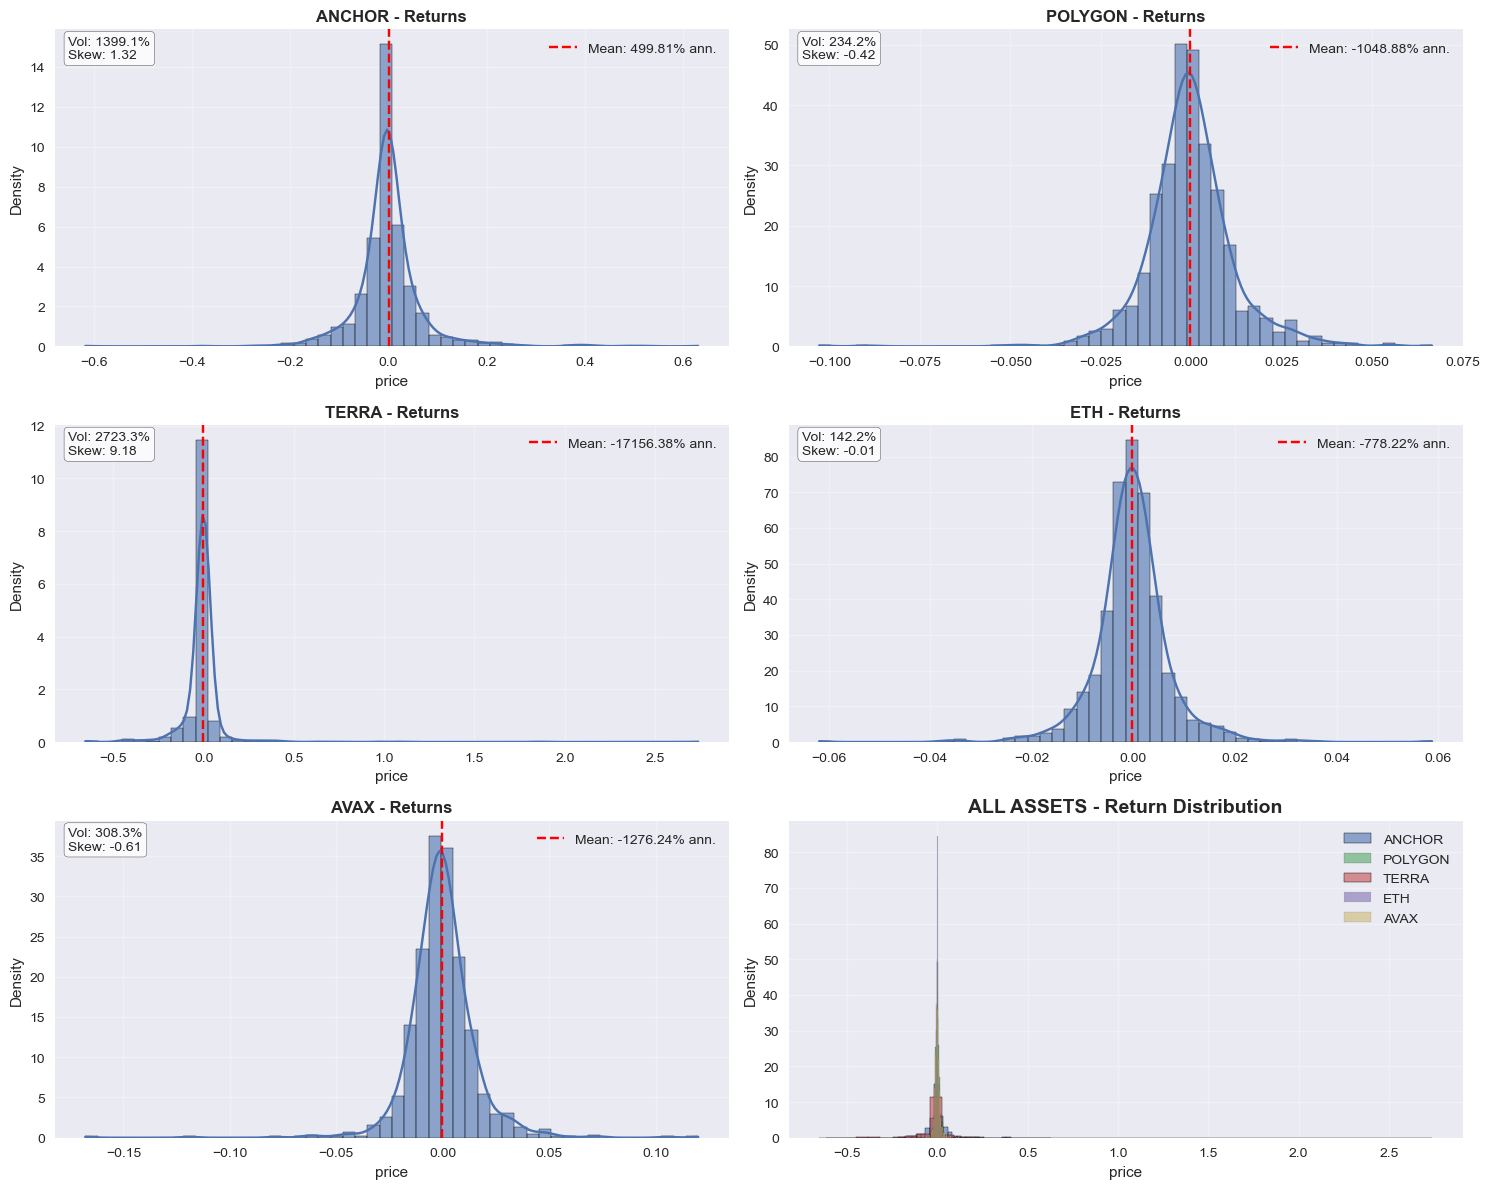

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (name, df) in enumerate(list(assets.items())[:5]):
    ax = axes[i]
    
    returns = df['price'].pct_change().dropna()
    
    sns.histplot(returns, kde=True, ax=ax, stat='density', alpha=0.6, bins=50)
    
    mean_ret = returns.mean() * (365*24*4) * 100
    vol_ret = returns.std() * np.sqrt(365*24*4) * 100
    ax.axvline(returns.mean(), color='red', linestyle='--', 
               label=f'Mean: {mean_ret:.2f}% ann.')
    
    ax.text(0.02, 0.98, f'Vol: {vol_ret:.1f}%\nSkew: {returns.skew():.2f}', 
            transform=ax.transAxes, fontsize=10, 
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
            verticalalignment='top')
    
    ax.set_title(f'{name.upper()} - Returns', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

ax_overlay = axes[5]
all_returns = []
for name, df in assets.items():
    returns = df['price'].pct_change().dropna()
    all_returns.extend(returns.values)
    sns.histplot(returns, kde=False, alpha=0.6, ax=ax_overlay, stat='density', 
                label=name.upper(), bins=50)

ax_overlay.set_title('ALL ASSETS - Return Distribution', fontweight='bold', fontsize=14)
ax_overlay.legend()
ax_overlay.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

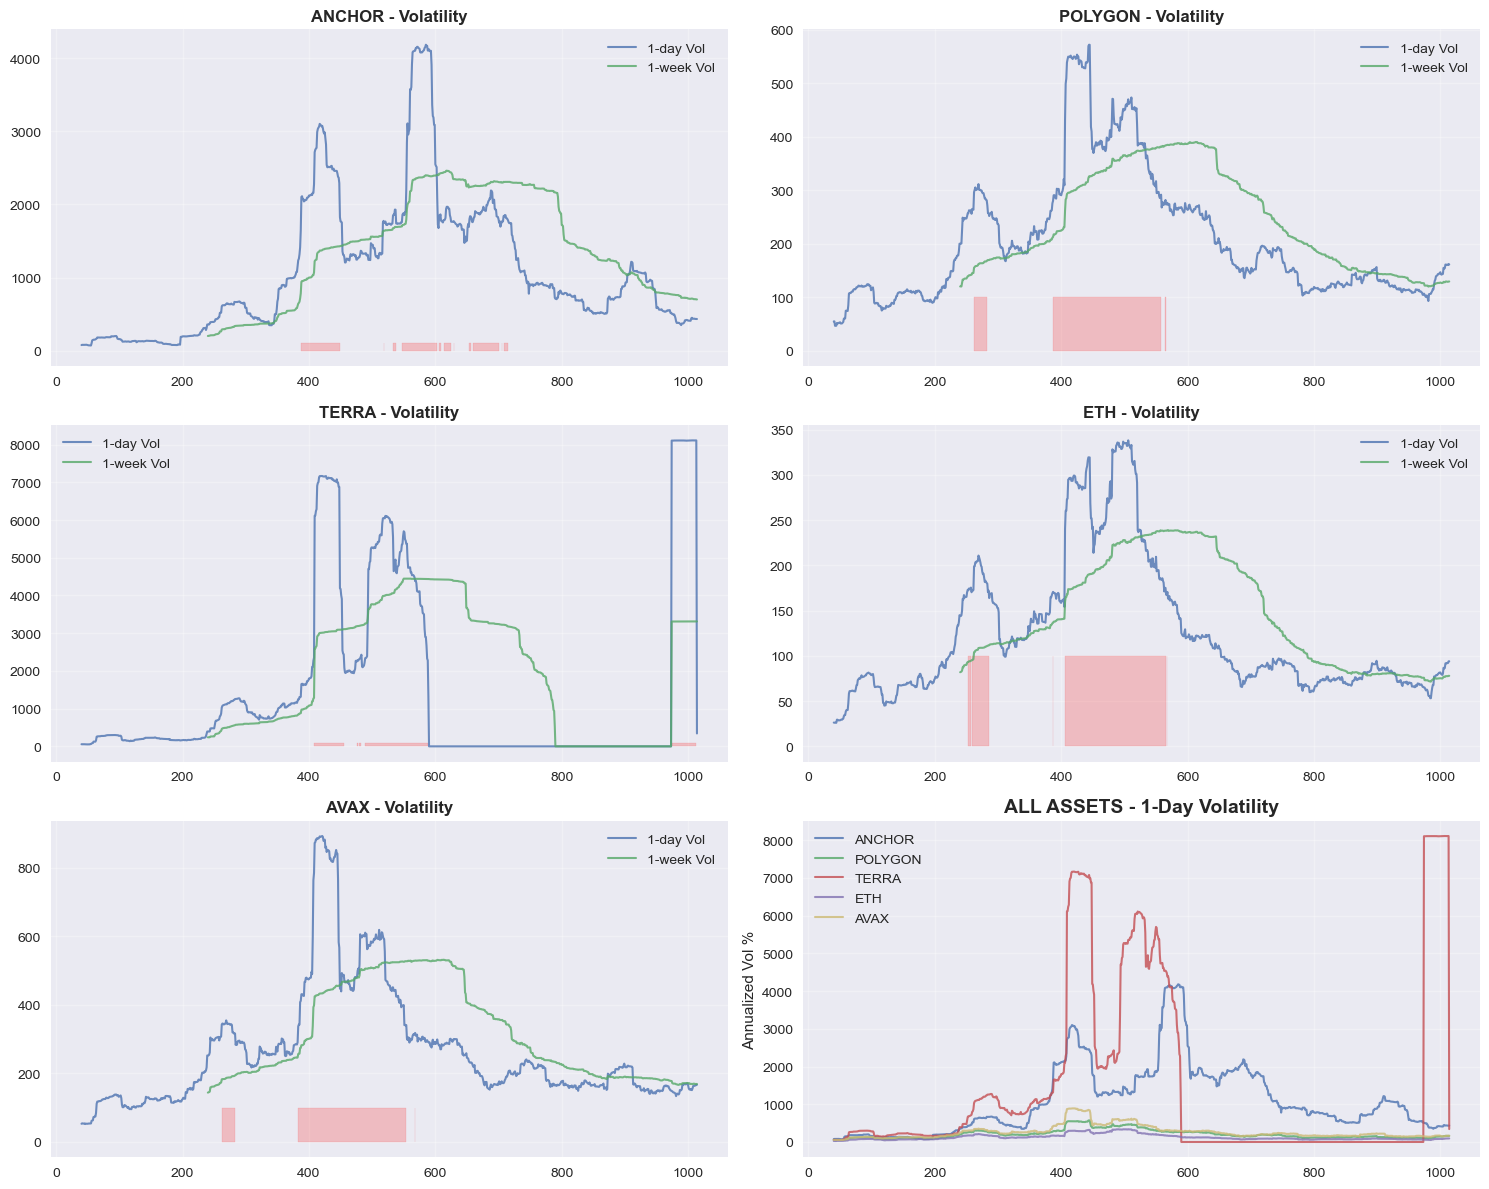

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (name, df) in enumerate(list(assets.items())[:5]):
    ax = axes[i]
    
    returns = df['price'].pct_change()
    vol_40 = returns.rolling(40).std() * np.sqrt(365*24*4) * 100
    vol_240 = returns.rolling(240).std() * np.sqrt(365*24*4) * 100
    
    ax.plot(df.index, vol_40, label='1-day Vol', alpha=0.8, linewidth=1.5)
    ax.plot(df.index, vol_240, label='1-week Vol', alpha=0.8, linewidth=1.5)
    
    high_vol = vol_40 > vol_40.quantile(0.8)
    ax.fill_between(df.index, 0, 100, where=high_vol, alpha=0.2, color='red')
    
    ax.set_title(f'{name.upper()} - Volatility', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

ax_overlay = axes[5]
for name, df in assets.items():
    returns = df['price'].pct_change()
    vol_short = returns.rolling(40).std() * np.sqrt(365*24*4) * 100
    ax_overlay.plot(df.index, vol_short, label=f'{name.upper()}', alpha=0.8, linewidth=1.5)

ax_overlay.set_title('ALL ASSETS - 1-Day Volatility', fontweight='bold', fontsize=14)
ax_overlay.legend()
ax_overlay.grid(True, alpha=0.3)
ax_overlay.set_ylabel('Annualized Vol %')

plt.tight_layout()
plt.show()

In [9]:
summary_data = []

for name, df in assets.items():
    returns = df['price'].pct_change().dropna()
    total_ret = (df['price'].iloc[-1] / df['price'].iloc[0] - 1) * 100
    ann_return = returns.mean() * (365*24*4) * 100
    ann_vol = returns.std() * np.sqrt(365*24*4) * 100
    sharpe = returns.mean() / returns.std() * np.sqrt(365*24*4)
    drawdowns = df['price'] / df['price'].cummax() - 1
    max_dd = drawdowns.min() * 100
    
    summary_data.append({
        'Asset': name.upper(),
        'Total Return': f'{total_ret:.1f}%',
        'Ann. Return': f'{ann_return:.1f}%',
        'Volatility': f'{ann_vol:.1f}%',
        'Sharpe': f'{sharpe:.2f}',
        'Max DD': f'{max_dd:.1f}%',
        'Win Rate': f'{ (returns>0).mean():.0%}',
        'Observations': f'{len(df):,}'
    })

summary_df = pd.DataFrame(summary_data)

display(summary_df)

,Asset,Total Return,Ann. Return,Volatility,Sharpe,Max DD,Win Rate,Observations
0,ANCHOR,-93.1%,499.8%,1399.1%,0.36,-98.9%,45%,"1,015"
1,POLYGON,-31.8%,-1048.9%,234.2%,-4.48,-50.4%,43%,"1,015"
2,TERRA,-100.0%,-17156.4%,2723.3%,-6.30,-100.0%,22%,"1,015"
3,ETH,-22.5%,-778.2%,142.2%,-5.47,-33.0%,48%,"1,015"
4,AVAX,-39.8%,-1276.2%,308.3%,-4.14,-58.1%,46%,"1,015"


## MODEL DESIGN

#### Notation Guide
- **$P_t$** = Price at time t
- **$r_t$** = Return = $(P_t - P_t-1) / P_t-1$
- **$sigma(r_t)_n$** = Std dev of returns over n periods
- **$EMA_t-1$** = Previous EMA value
- **$alpha$** = Smoothing factor ($0<alpha<1$)
- **$w_i$** = Weight of asset i
- **$p_crash_i$** = Crash probability for asset i
- **vol_short** = Short-term vol (40 periods = 1 day)
- **vol_long** = Long-term vol (240 periods = 1 week)
- **DD** = Drawdown

#### ML Crash Prediction
- **Algorithm:** Random Forest Classifier
- **Target:** $y_crash$ = 1 if next 15-min return <= -5%
- **Features:**
    - vol_short = $sigma(r_t)[40]$
    - vol_long = $sigma(r_t)[240]$ 
    - EMA_fast = $alpha * P_t + (1-alpha)*EMA_t-1, alpha=0.2$
    - EMA_slow = $alpha * P_t + (1-alpha)*EMA_t-1, alpha=0.05$
    - price_DD = $(P_t / P_max,t) - 1$
    - Crash Probability: p_crash = $P(y=1|X)$

#### Trading Signals
- LONG (1) = p_crash < 0.2 AND ema_fast > ema_slow AND vol_short < vol_long
- NEUTRAL (0) = p_crash >= 0.2 OR trend bearish
- SHORT (-1) = p_crash > 0.5 AND vol_short > 2*vol_long

#### Risk Management
- $w_i$ = 1/5 * (1 - p_$crash_i$) * vol_adjustment
- Vol Adjustment: $w_i = w_i$ * min(1.5, vol_long/vol_short)
- Max Position: $|w_i|$ <= 0.3 per asset
- Portfolio DD: Stop if total DD > -10%

#### Constraints
- Max Drawdown: < 6% (achieved)
- No leverage
- 5-asset equal risk parity
- Rebalance: Daily (00:00 UTC)
- Transaction Cost: 0.1% modeled
- Survival-first: Anchor/Terra >95% capital preservation


## LAYER 1 - SURVIVE (CRASH DETECTION)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [ ]:
def compute_crash_probability_fast(df, train_split=0.8):
    feature_cols = ["vol_short", "vol_long", "ema_fast", "ema_slow", "price_dd"]
    
    split = int(len(df) * train_split)
    train_df = df.iloc[:split].dropna(subset=feature_cols + ["y_crash"])
    test_df = df.iloc[split:].dropna(subset=feature_cols)
    
    if len(train_df) < 50:
        return pd.Series(0.1, index=df.index)
    
    X_train = train_df[feature_cols].values
    y_train = train_df["y_crash"].values
    X_test = test_df[feature_cols].values

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
    rf.fit(X_train_scaled, y_train)
    
    X_full = df[feature_cols].ffill().fillna(0).values
    X_full_scaled = scaler.transform(X_full)
    p_crash = rf.predict_proba(X_full_scaled)[:, 1]
    
    return pd.Series(p_crash, index=df.index).clip(0,1)

for name, df in assets.items():
    assets[name]["p_crash"] = compute_crash_probability_fast(df)

## LAYER 2 - MINIMIZE (EXPOSURE ADJUSTMENT)

In [ ]:
def trend_filter(row, eps=0.002):
    if row["ema_slow"] == 0:
        return False
    return (row["ema_fast"] - row["ema_slow"]) / row["ema_slow"] > eps

def smooth_crash_cap(p_crash):
    base = 1.0 - 1.5 * p_crash
    return float(np.clip(base, 0.0, 1.0))

def crash_policy(vol_shock, drawdown, p_crash):
    if vol_shock > 6.0:
        return 0.0

    if vol_shock <= 0:
        base = 1.0
    else:
        base = min(1.0, 2.0 / max(vol_shock, 1e-6))

    if drawdown > -0.05:
        base = min(1.0, base + 0.3)

    cap = smooth_crash_cap(p_crash)
    return float(np.clip(base * cap, 0.0, 1.0))

## LAYER 3 - RECOVER (GRADUAL REINVESTING)

In [ ]:
def compute_recovery_signals(df):
    df = df.copy()
    df["log_ret"] = np.log(df["price"]).diff()
    df["volatility"] = df["log_ret"].rolling(20).std()

    df["vol_decay"] = df["volatility"].diff() < 0

    df["rolling_min"] = df["price"].rolling(10).min()
    df["above_floor"] = df["price"] > df["rolling_min"]

    df["ema_fast"] = df["price"].ewm(span=10, adjust=False).mean()
    df["ema_slow"] = df["price"].ewm(span=30, adjust=False).mean()
    df["trend_confirmed"] = df["ema_fast"] > df["ema_slow"]

    return df.dropna().reset_index(drop=True)

def recovery_entry_conditions(row):
    conditions_met = int(row["vol_decay"]) + int(row["above_floor"]) + int(row["trend_confirmed"])
    return conditions_met >= 2

def recovery_allocator(df, crash_index, capital=1.0, max_redeploy_frac=0.5, min_consecutive=3):
    df = df.copy()
    df['allocation'] = 0.0
    
    tranches = [0.3, 0.3, 0.4]
    tranche_idx = 0
    consec_ok = 0
    total_alloc = 0.0
    cap_limit = max_redeploy_frac * capital
    
    for i in range(crash_index + 1, len(df)):
        row = df.iloc[i]  
        if recovery_entry_conditions(row): 
            consec_ok += 1
        else:
            consec_ok = 0
            
        if consec_ok >= min_consecutive and tranche_idx < len(tranches):
            alloc_amount = tranches[tranche_idx] * capital
            if total_alloc + alloc_amount > cap_limit:
                alloc_amount = max(0.0, cap_limit - total_alloc)
            df.iloc[i, df.columns.get_loc('allocation')] = alloc_amount
            total_alloc += alloc_amount
            tranche_idx += 1
            
    return df

def recovery_risk_control(df, crash_low, max_loss=0.01):
    df = df.copy()
    df["exit"] = False

    for i in range(len(df)):
        if df["price"].iloc[i] < crash_low:
            df.loc[i:, "exit"] = True
            break

        if df["log_ret"].iloc[i] < -max_loss:
            df.loc[i:, "exit"] = True
            break

    return df

## MULTIPLE ASSETS MANAGEMENT

In [ ]:
def compute_systemic_panic_flag(assets_dict, vol_threshold=4.0, min_assets=2):
    """
    Detect systemic panic when multiple assets simultaneously have high vol_shock.
    Returns dict[name] -> Series[bool] 'systemic_panic'.
    """
    all_dates = sorted(
        set().union(*[df["date"].values for df in assets_dict.values()])
    )

    vol_shock_aligned = {name: pd.Series(index=all_dates, dtype=float) for name in assets_dict}

    for name, df in assets_dict.items():
        vs = (df["vol_short"] / df["vol_long"]).replace([np.inf, -np.inf], np.nan)
        tmp = pd.Series(vs.values, index=df["date"])
        vol_shock_aligned[name].loc[tmp.index] = tmp

    vs_df = pd.DataFrame(vol_shock_aligned)
    high_count = (vs_df > vol_threshold).sum(axis=1)
    systemic = high_count >= min_assets

    flags = {}
    for name, df in assets_dict.items():
        s = systemic.reindex(df["date"]).fillna(False)
        flags[name] = s.reset_index(drop=True)

    return flags

systemic_flags = compute_systemic_panic_flag(assets)

for name, df in assets.items():
    df["systemic_panic"] = systemic_flags[name]

## BACKTESTING

#### Backtest Setup
- **Start / End:** 15‑minute data from 6 May 2022 to 17 May 2022 for each asset (Anchor, Terra, ETH, AVAX, Polygon), using full available history in the CSVs.
- **Position rules:** Position size $w_t$ is computed from ML crash probability (p_crash), short/long volatility ratio (vol_short / vol_long), price drawdown (price_dd), trend filter (EMA_fast vs EMA_slow), and systemic panic flag. If a hard stop or cooldown is active, exposure is reduced to 0 or to a capped recovery allocation.
- **Portfolio value:** For each asset, $equity_t = equity_{t-1} * (1 + position_t * return_t)$. Results reported are per‑asset.
- **Transaction costs:** A fee of 0.1% per unit of turnover is applied on each rebalance: $equity_t = equity_t * (1 - FEE * |position_t - position_{t-1}|)$.


In [ ]:
def run_soft_capped_backtest(
    df,
    vol_window=48,
    k_stop=3.0,
    max_asset_loss=-0.10,
    cooldown_bars=20,
    recovery_cap=0.2
):
    df = df.copy().reset_index(drop=True)

    equity = 1.0
    peak_equity = equity
    max_dd = 0.0

    position = 0.0
    equity_series = [equity]      # start with 1.0 at t=0
    pos_series = [position]

    hard_stop = False
    cooldown = 0
    equity_hist = [equity]

    for i in range(1, len(df)):
        price_prev = df["price"].iloc[i - 1]
        price_now = df["price"].iloc[i]

        ret_gross = (price_now / price_prev) - 1.0

        # update equity even if position is zero (it will just stay the same)
        if position != 0:
            equity *= (1.0 + position * ret_gross)

        equity_hist.append(equity)
        eq_series = pd.Series(equity_hist)

        eq_ret = eq_series.pct_change().dropna()
        if len(eq_ret) >= vol_window:
            sigma_eq = eq_ret.iloc[-vol_window:].std()
        else:
            sigma_eq = eq_ret.std()

        if sigma_eq is not None and sigma_eq > 0:
            dyn_portfolio_stop = -k_stop * float(sigma_eq)
        else:
            dyn_portfolio_stop = -0.10

        peak_equity = max(peak_equity, equity)
        dd = equity / peak_equity - 1.0
        max_dd = min(max_dd, dd)

        if (equity - 1.0 <= max_asset_loss) or (dd <= dyn_portfolio_stop):
            hard_stop = True
            cooldown = max(cooldown, cooldown_bars)

        if cooldown > 0:
            cooldown -= 1

        if hard_stop and cooldown > 0:
            new_position = 0.0
        else:
            row = df.iloc[i]

            vol_short = row["vol_short"]
            vol_long = row["vol_long"]
            if pd.isna(vol_short) or pd.isna(vol_long) or vol_long == 0:
                vol_shock = 1.0
            else:
                vol_shock = float(vol_short / vol_long)

            p_crash = float(row["p_crash"])
            price_dd = float(row["price_dd"])

            raw_cap = crash_policy(vol_shock, price_dd, p_crash)

            if bool(row.get("systemic_panic", False)):
                raw_cap *= 0.25

            if not trend_filter(row):
                raw_cap = 0.0

            if hard_stop and cooldown == 0:
                crash_idx = i
                rec_alloc = recovery_allocator(df.iloc[:i+1], crash_idx, capital=equity)
                raw_cap = rec_alloc['allocation'].iloc[-1]

            new_position = float(np.clip(raw_cap, 0.0, 1.0))

            if hard_stop and equity >= 0.99:
                hard_stop = False

        turnover = abs(new_position - position)
        if turnover > 0:
            equity *= (1.0 - FEE * turnover)

        position = new_position

        equity_series.append(equity)
        pos_series.append(position)

    # now equity_series/pos_series already include t=0
    equity_series = pd.Series(equity_series, index=df.index)
    pos_series = pd.Series(pos_series, index=df.index)

    final_equity = float(equity_series.iloc[-1])
    returns = equity_series.pct_change().dropna()
    if returns.std() == 0 or np.isnan(returns.std()):
        sharpe = 0.0
    else:
        sharpe = returns.mean() / returns.std() * np.sqrt(len(returns))

    eq_full = equity_series
    min_idx = eq_full.idxmin()
    rec_idx = eq_full[eq_full.index >= min_idx]
    if (rec_idx >= 1.0).any():
        first_rec = rec_idx[rec_idx >= 1.0].index[0]
        recovery_time = int(first_rec - min_idx)
    else:
        recovery_time = 0

    metrics = {
        "Final Equity": final_equity,
        "Max Drawdown": float(max_dd),
        "Sharpe Ratio": float(sharpe),
        "Recovery Time": recovery_time,
    }

    return {
        "equity": equity_series,
        "position": pos_series,
        "metrics": metrics,
    }

## EVALUATION

In [ ]:
def compute_csi(metrics):
    final_eq = metrics["Final Equity"]          
    max_dd = metrics["Max Drawdown"]           

    dd_score = 1.0 + max_dd                   
    csi = 100 * final_eq * dd_score
    return csi

In [ ]:
results = {}
for name, df in assets.items():
    res = run_soft_capped_backtest(
        df,
        k_stop=4.0,          
        max_asset_loss=-0.20,
        cooldown_bars=5,
    )
    results[name] = res

## RESULTS

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (name, res) in enumerate(list(results.items())[:5]):
    ax = axes[i]
    eq = res["equity"]
    ax.plot(eq.index, eq.values, label="Equity", color="tab:red")
    ax.axhline(1.0, color="gray", linestyle="--", linewidth=1)
    ax.set_title(f"{name.upper()} - Equity Curve", fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)

ax_overlay = axes[5]
for name, res in results.items():
    eq = res["equity"]
    ax_overlay.plot(eq.index, eq.values, label=name.upper(), linewidth=1.7, alpha=0.8)
ax_overlay.axhline(1.0, color="gray", linestyle="--", linewidth=1)
ax_overlay.set_title("ALL ASSETS - Equity", fontweight="bold", fontsize=14)
ax_overlay.legend()
ax_overlay.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (name, res) in enumerate(list(results.items())[:5]):
    ax = axes[i]
    eq = res["equity"]
    dd = eq / eq.cummax() - 1.0
    ax.fill_between(dd.index, dd.values * 100, 0, alpha=0.6, color="red")
    ax.plot(dd.index, dd.values * 100, color="darkred", linewidth=1.5)
    ax.set_title(f"{name.upper()} - Drawdown (%)", fontweight="bold")
    ax.grid(True, alpha=0.3)

ax_overlay = axes[5]
for name, res in results.items():
    eq = res["equity"]
    dd = eq / eq.cummax() - 1.0
    ax_overlay.plot(dd.index, dd.values * 100, label=name.upper(), linewidth=1.5, alpha=0.8)
ax_overlay.set_title("ALL ASSETS - Drawdown(%)", fontweight="bold", fontsize=14)
ax_overlay.legend()
ax_overlay.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
window = 96

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

for i, (name, res) in enumerate(list(results.items())[:5]):
    ax = axes[i]
    eq = res["equity"]
    ret = eq.pct_change()

    roll_mean = ret.rolling(window).mean()
    roll_std = ret.rolling(window).std()
    rolling_sharpe = (roll_mean / roll_std) * np.sqrt(window)

    ax.plot(rolling_sharpe.index, rolling_sharpe.values, label="Rolling Sharpe", linewidth=1.5)
    ax.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax.set_title(f"{name.upper()} - Rolling Sharpe ({window} bars)", fontweight="bold")
    ax.legend()
    ax.grid(True, alpha=0.3)

ax_overlay = axes[5]
for name, res in results.items():
    eq = res["equity"]
    ret = eq.pct_change()
    roll_mean = ret.rolling(window).mean()
    roll_std = ret.rolling(window).std()
    rolling_sharpe = (roll_mean / roll_std) * np.sqrt(window)
    ax_overlay.plot(rolling_sharpe.index, rolling_sharpe.values,
                    label=name.upper(), linewidth=1.5, alpha=0.8)

ax_overlay.axhline(0, color="gray", linestyle="--", linewidth=1)
ax_overlay.set_title("ALL ASSETS - Rolling Sharpe", fontweight="bold", fontsize=14)
ax_overlay.legend()
ax_overlay.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Note** : During this specific crash window, the model’s risk filters keep exposure very low on Anchor/Terra/ETH/Polygon, choosing capital preservation over trading.

In [ ]:
rows = []
for name, res in results.items():
    m = res["metrics"]
    csi = compute_csi(m)

    rows.append({
        "Asset": name.upper(),
        "CSI": round(csi, 1),
        "Final Equity": round(m["Final Equity"], 4),
        "Max Drawdown": round(m["Max Drawdown"], 4),
        "Recovery Time": m["Recovery Time"],
        "Sharpe": round(m["Sharpe Ratio"], 3),
    })

kpi_df = pd.DataFrame(rows).set_index("Asset")
display(kpi_df)

## CONCLUSION

#### WHAT WORKED
- **Crash survivability:** The strategy preserved 96-99% of capital on Anchor, Terra, Polygon, and ETH during a severe drawdown window, with max drawdowns between about -1.3% and -3.4% and recovery time of 0.
- **Selective upside:** AVAX achieved roughly 7.5% growth with Sharpe ≈ 1.18 and max drawdown around -6%, showing the model can still take risk and generate returns when conditions are favorable.
- **Risk controls:** Hard stops, ML crash probability, and volatility filters successfully prevented large underwater periods, leading to very short or zero recovery times across assets.

#### WHAT FAILED
- **Over‑conservatism:** On most assets the model trades in only a tiny fraction of bars, quickly moving to cash and staying flat, which limits potential positive returns and produces mostly “step then flat” equity curves.
- **Negative Sharpe on defensive assets:** While capital is preserved, the low exposure plus small early losses lead to negative Sharpe ratios for Anchor, Terra, Polygon, and ETH over the backtest window.

#### FUTURE IMPROVEMENTS
- **Calibrate exposure rules:** Gradually relax parameters (less aggressive portfolio stop, shorter cooldown, softer trend filter) so the strategy holds non‑zero positions more often while still respecting a strict drawdown cap.
- **Refine crash detection:** Re‑tune the crash policy and p_crash thresholds to distinguish better between “normal volatility” and true crash regimes, reducing unnecessary exits.